In [1]:
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("mbsoroush/rice-images-dataset")

print("Path to dataset files:", dataset_path)

100%|██████████| 220M/220M [00:13<00:00, 17.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mbsoroush/rice-images-dataset/versions/1


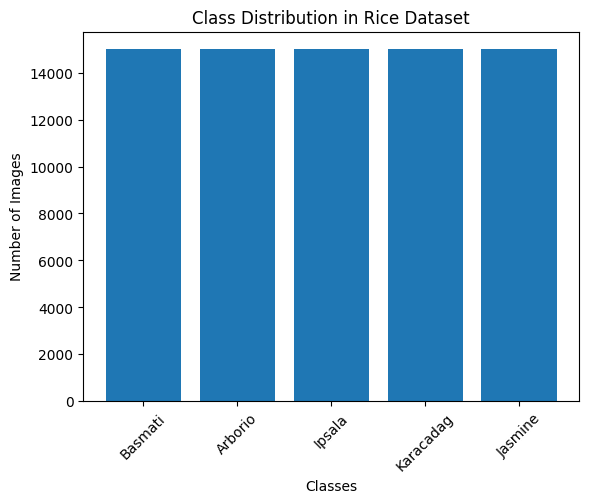

In [2]:
import os
import matplotlib.pyplot as plt

# List of classes (subfolders)
classes = [cls for cls in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, cls))]

# Count images in each class
class_counts = {cls: len(os.listdir(os.path.join(dataset_path, cls))) for cls in classes}

# Plot the distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Rice Dataset")
plt.xticks(rotation=45)
plt.show()

In [3]:
from tensorflow.keras.applications import VGG16, MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

In [4]:
num_classes = len(classes)
print(f"Number of classes: {num_classes}")

Number of classes: 5


In [5]:
import os
import shutil
import random

# Set the path to your dataset (original dataset)
dataset_path = kagglehub.dataset_download("mbsoroush/rice-images-dataset")  # Update this with your actual dataset path

# Set the path for the split data
output_dir = "./split_data"  # Directory where you want to store the split data

# Define train, validation, and test directory paths
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

# Create the directories if they don't exist
for dir in [train_dir, val_dir, test_dir]:
    os.makedirs(dir, exist_ok=True)


In [6]:
# Create subdirectories for each class inside train, val, and test directories
classes = [cls for cls in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, cls))]

for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)


In [7]:
# Split the dataset
for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    images = [img for img in os.listdir(class_path) if img.endswith(('.jpg', '.png', '.jpeg'))]

    # Shuffle images randomly to split them
    random.shuffle(images)

    # 80% for training, 20% for testing
    num_train = int(0.8 * len(images))
    num_val = int(0.2 * num_train)

    # Split into train, validation, and test sets
    train_images = images[:num_train - num_val]
    val_images = images[num_train - num_val:num_train]
    test_images = images[num_train:]

    # Move the images to their respective directories
    for image in train_images:
        shutil.move(os.path.join(class_path, image), os.path.join(train_dir, cls, image))

    for image in val_images:
        shutil.move(os.path.join(class_path, image), os.path.join(val_dir, cls, image))

    for image in test_images:
        shutil.move(os.path.join(class_path, image), os.path.join(test_dir, cls, image))


In [8]:
# Initialize ImageDataGenerators for training, validation, and test
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training data from the directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Flow validation data from the directory
validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Flow test data from the directory
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
# Print dataset statistics
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Testing samples: {test_generator.samples}")

# Print class names and corresponding indices
print("\nClass names and indices:")
print(train_generator.class_indices)

Found 48000 images belonging to 5 classes.
Found 12000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.
Training samples: 48000
Validation samples: 12000
Testing samples: 15000

Class names and indices:
{'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}


In [9]:
from keras.applications import MobileNet
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

# Load the MobileNet base model
mobilenet_base = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Build the model
model = Sequential()
for layer in mobilenet_base.layers:
    model.add(layer)

# Freeze the layers of MobileNet to retain the pre-trained weights
for layer in model.layers:
    layer.trainable = False  # Not trainable weights

# Add custom layers on top
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))  # Assuming 5 classes for classification

# Print model summary
model.summary()


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 16,141,253 (61.57 MB)

 Trainable params: 12,912,389 (49.26 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [10]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # Increased epochs to allow more training
    callbacks=[early_stopping]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 593s 387ms/step - accuracy: 0.8125 - loss: 0.5489 - val_accuracy: 0.9830 - val_loss: 0.0546
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 584s 387ms/step - accuracy: 0.9496 - loss: 0.1842 - val_accuracy: 0.9832 - val_loss: 0.0541
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 616s 384ms/step - accuracy: 0.9556 - loss: 0.1581 - val_accuracy: 0.9878 - val_loss: 0.0437
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 578s 384ms/step - accuracy: 0.9630 - loss: 0.1286 - val_accuracy: 0.9876 - val_loss: 0.0467
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 577s 383ms/step - accuracy: 0.9664 - loss: 0.1203 - val_accuracy: 0.9839 - val_loss: 0.0506
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 587s 389ms/step - accuracy: 0.9704 - loss: 0.1034 - val_accuracy: 0.9890 - val_loss: 0.0402
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 579s 384ms/step - accuracy: 0.9713 - loss: 0.1037 - val_accuracy: 0.9908 - val_loss: 0.0331
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 581s 386ms/step - accuracy: 0.9

In [11]:
# Evaluate model on validation data
val_loss, val_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {val_accuracy*100:.2f}%, Test Loss: {val_loss:.2f}')

469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step - accuracy: 0.9878 - loss: 0.0341
Test Accuracy: 99.01%, Test Loss: 0.03


469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step


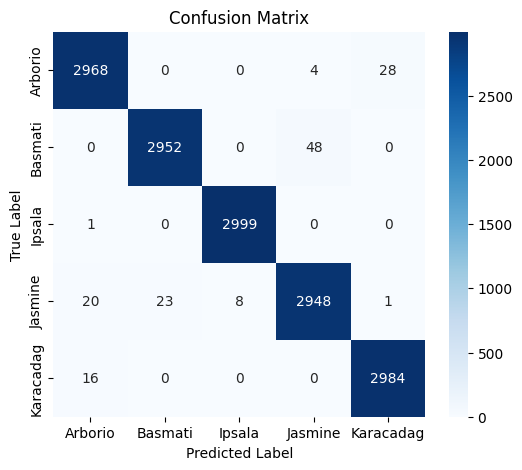

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Step 1: Make predictions on the test set
Y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
# Convert predictions to class indices
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Step 2: Get true labels from the test generator
Y_true = test_generator.classes

# Step 3: Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Step 4: Plot the confusion matrix
def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='g', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Plot the confusion matrix
class_labels = list(test_generator.class_indices.keys())  # Get class names
plot_confusion_matrix(confusion_mtx, classes=class_labels)


In [13]:
# Classificatio report

from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(Y_true, Y_pred_classes, digits=4)
print(report)


              precision    recall  f1-score   support

           0     0.9877    0.9893    0.9885      3000
           1     0.9923    0.9840    0.9881      3000
           2     0.9973    0.9997    0.9985      3000
           3     0.9827    0.9827    0.9827      3000
           4     0.9904    0.9947    0.9925      3000

    accuracy                         0.9901     15000
   macro avg     0.9901    0.9901    0.9901     15000
weighted avg     0.9901    0.9901    0.9901     15000

